# Generate example WRG file

This example generates an example wrg file which can be used in later examples.

WRG files are Wind Resource Grid files, and their structure is defined here: https://backend.orbit.dtu.dk/ws/portalfiles/portal/116352660/WAsP_10_Help_Facility.pdf

In [22]:
from floris import WindRose

import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [2]:
# Top line parameters
Nx = 3 # Number of grid points in x
Ny = 3 # Number of grid points in y
Xmin = 0.0 # Minimum value of x (m)
Ymin = 0.0 # Minimum value of y (m)
cell_size = 1000.0 # Grid spacing (m)

# Other fixed parameters
z_coord = 0.0 # z-coordinate of the grid
height_above_ground_level = 90.0 # Height above ground level
num_sectors = 12 # Number of direction sectors

## Generating data

The above parameters define a 3x3 grid of points.  Let's start by assuming the point at (0,0) has the wind rose as defined in inputs/wind_rose.csv

<PolarAxes: >

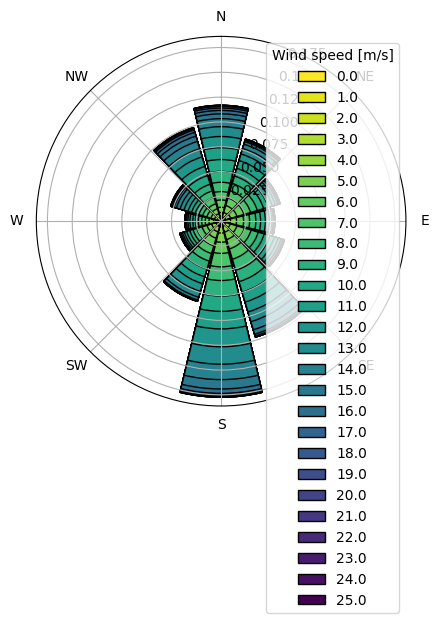

In [63]:
wind_rose_base = WindRose.read_csv_long(
    "../inputs/wind_rose.csv", wd_col="wd", ws_col="ws", freq_col="freq_val", ti_col_or_value=0.06
)

# Resample to number of sectors
wind_rose_base = wind_rose_base.aggregate(wd_step=360/num_sectors)

wind_rose_base.plot()

## Generate the other wind roses

Assume that the wind roses at other points are generated by rotating the wind rose as y increases increasing the velocity as x increases.

In [67]:
x_list = []
y_list = []
wind_rose_list = []
n_bins_per_step = 1
scale_factor = 0.4

for xi in range(Nx):
    for yi in range(Ny):    

        # Get the x and y locations for this point
        x = Xmin + xi * cell_size
        y = Ymin + yi * cell_size
        x_list.append(x)
        y_list.append(y)

        # Instantiate the wind rose object
        wind_rose = WindRose.read_csv_long(
            "../inputs/wind_rose.csv", wd_col="wd", ws_col="ws", freq_col="freq_val", ti_col_or_value=0.06
        )

        # Resample to number of sectors
        wind_rose = wind_rose.aggregate(wd_step=360/num_sectors)

        # Rotate the wind rose
        rotate_steps = yi * n_bins_per_step
        freq_table = wind_rose.freq_table.copy()
        freq_table_new = freq_table.copy()
        freq_table_new[rotate_steps:,:] = freq_table[0:freq_table.shape[0]-rotate_steps,:]
        freq_table_new[:rotate_steps,:] = freq_table[freq_table.shape[0]-rotate_steps:,:]

        # Scale the wind rose
        scale_vector = np.linspace(1-scale_factor * xi, 1+scale_factor *xi, freq_table.shape[1])
        
        # Slace freq_table_new using scale_vector along the wind speed axis
        freq_table_new = freq_table_new * scale_vector

        # Add to list
        wind_rose_list.append(WindRose(
            wind_directions=wind_rose.wind_directions,
            wind_speeds=wind_rose.wind_speeds,
            ti_table=wind_rose.ti_table,
            freq_table=freq_table_new))


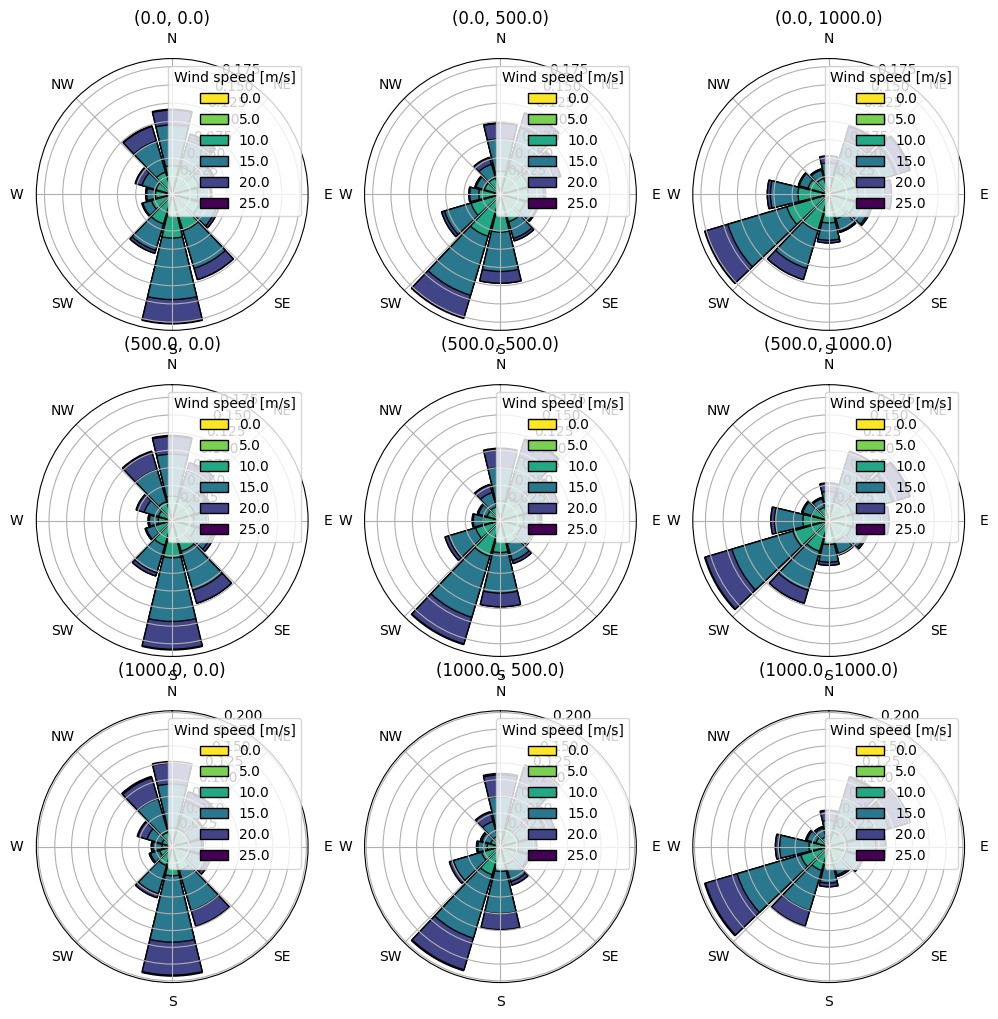

In [68]:
# Show the wind roses in a grid
fig, axarr = plt.subplots(Nx, Ny, figsize=(12, 12),subplot_kw={"polar": True})
axarr = axarr.flatten()

for i, wind_rose in enumerate(wind_rose_list):

    wind_rose.plot(ax=axarr[i], ws_step=5)
    axarr[i].set_title(f"({x_list[i]}, {y_list[i]})")

A: 10.601377093906066, k: 2.734403995194797


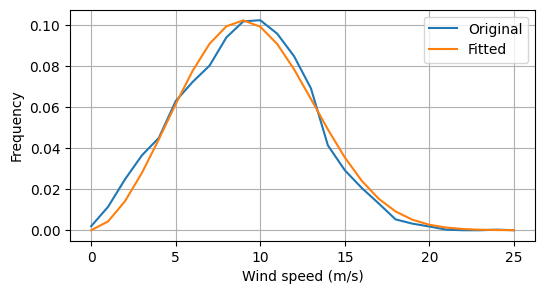

In [94]:
# Define a function given the distribution of wind speeds in one sector, compute the A and k parameters of the Weibull distribution
def weibull_func(U, A, k):
    return (k / A) * (U / A)**(k-1) * np.exp(-(U / A)**k)

from scipy.optimize import curve_fit
def estimate_weibull(U, freq):

    # Normalize the frequency
    freq = freq / freq.sum()
   
    # Fit the Weibull distribution
    popt, _ = curve_fit(weibull_func, U, freq, p0=(6.0, 2.0))
    A_fit, k_fit = popt

    return A_fit, k_fit

freq_test =  wind_rose_list[0].freq_table[0,:] / wind_rose_list[0].freq_table[0,:].sum()
a_test,k_test = estimate_weibull(wind_rose_list[0].wind_speeds, freq_test)
print(f"A: {a_test}, k: {k_test}")

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(wind_rose_list[0].wind_speeds,freq_test, label="Original")
ax.plot(wind_rose_list[0].wind_speeds, weibull_func(wind_rose_list[0].wind_speeds, a_test, k_test), label="Fitted")
ax.legend()
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Frequency")
ax.grid(True)

## Write out the WRG file

In [95]:
# Open the file 
with open("wrg_example.wrg", "w") as f:

    # Write the top line of the file
    f.write(f"{Nx} {Ny} {Xmin} {Ymin} {cell_size}\n")

    # Now loop over the points
    for i in range(Nx * Ny):
        
        # Get the wind rose for this point
        wind_rose = wind_rose_list[i]